## **Modeling and Preprocessing**

### **Import Library**

In [1]:
import pandas as pd
import numpy as np
import time
from datetime import timedelta
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
%matplotlib inline

### **Import Data**

In [2]:
df = pd.read_csv('../data/clean_df.csv', 
                  engine='python'
                )

In [3]:
df.drop(columns='Unnamed: 0', inplace=True)

In [4]:
df.head()

,subreddit,year,text,tokenized,lemmatized,clean_text
0,1,2019,how to find the best offers and deals on lapda...,"['how', 'to', 'find', 'the', 'best', 'offers',...","['how', 'to', 'find', 'the', 'best', 'offer', ...",best offer deal lapdance shoe amp lingerie dea...
1,1,2019,columbia fleece various colors and sizes shipp...,"['columbia', 'fleece', 'various', 'colors', 'a...","['columbia', 'fleece', 'various', 'color', 'an...",columbia fleece various color size shipping in...
2,1,2019,pacsun vans old skool sizes free shipping,"['pacsun', 'vans', 'old', 'skool', 'sizes', 'f...","['pacsun', 'van', 'old', 'skool', 'size', 'fre...",pacsun van old skool size free shipping
3,1,2019,massive toadampco sale some items off noooo id...,"['massive', 'toadampco', 'sale', 'some', 'item...","['massive', 'toadampco', 'sale', 'some', 'item...",massive toadampco sale item off noooo idea err...
4,1,2018,chup socks for with code more,"['chup', 'socks', 'for', 'with', 'code', 'more']","['chup', 'sock', 'for', 'with', 'code', 'more']",chup sock code


### **Preprocessing**

We will assign the `lemmatized` text to X and `fmf` class to y. Then we will split the data into train and test sets before performing TF-IDF vectorizing so that the frequency isn't influenced by the random split of data before inputting the data into our model.

In [5]:
X = df[['clean_text']]
y = df['subreddit']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    stratify=y, 
                                                    random_state=42)

#### **TF-IDF**

We will use TF-IDF to affect how the weights of terms are distributed. Terms that occur very frequently across all documents will have their weights penalized and terms that occur very infrequently will have their weights increased.

Instantiate TF-IDF():
- **min_df=.03**: terms with a frequency of lower than 3% across all documents will be removed as these terms that occur so rarely will not contribute signal to our model.
- **max_df=.95**: terms with a frequency of greater than 95% across all documents will be removed as these terms are most likely in both subreddits and will not contribute signal to our model.

#### **Vectorize X_train and X_test**

#### X_train

In [7]:
tfidf = TfidfVectorizer(min_df=.03, max_df=.95)
X_train_tfidf = tfidf.fit_transform(X_train['clean_text'])
X_train_tfidf = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf.get_feature_names())

#### X_test

In [8]:
X_test_tfidf = tfidf.transform(X_test['clean_text'])
X_test_tfidf = pd.DataFrame(X_test_tfidf.toarray(), columns=tfidf.get_feature_names())

### **Modeling**

#### **Baseline Model**

In [9]:
y.value_counts(normalize=True)

0    0.539241
1    0.460759
Name: subreddit, dtype: float64

`r/sneakers` is our majority class. If we classify all posts as belonging in the `r/sneakers` subreddit, we will be predicting correctly 53.92% of the time.

#### **Logistic Regression**

Instantiate LogisticRegression() and perform Grid Search to find the most optimal hyperparameters:

- **Penalty:** `l1` (lasso) or `l2` (ridge) regularization
- **C:** Inverse of regularization strength

In [10]:
params_logr = {'penalty':['l1','l2'],
                'C': [0.01, 0.1, 1, 10]}

gs_logr = GridSearchCV(LogisticRegression(), 
                        param_grid=params_logr)
gs_logr.fit(X_train_tfidf, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

#### Best Gridsearched Params

In [11]:
gs_logr.best_params_

{'C': 1, 'penalty': 'l2'}

#### Accuracy Scores

In [12]:
gs_logr.score(X_train_tfidf, y_train)

0.789272819408374

In [13]:
gs_logr.score(X_test_tfidf, y_test)

0.7876959619952494

The accuracy score for the training set is slightly higher than compared to the accuracy score for the test set indicating slight overfitting.

#### Visualization of Features

Create a dataframe of the most important features and their exponential log weights of odds from our model. Assign the word to the respective weights.

In [14]:
features = pd.DataFrame(np.exp(gs_logr.best_estimator_.coef_), columns=X_train_tfidf.columns).T

In [15]:
features.columns = ['odds']

The top 10 features of our model with the greatest odds.

In [16]:
features.sort_values(by='odds', ascending=False)[['odds']].head(10)

,odds
sale,103.550928
code,91.217825
item,84.621235
free,39.509298
off,14.135473
shipping,11.628264
price,5.741240
size,4.043251
new,0.983314
day,0.755850


The top 10 features of our model with the lowest odds.

In [17]:
features.sort_values(by='odds', ascending=True)[['odds']].head(10)

,odds
nike,0.217118
sneaker,0.218174
got,0.333686
pair,0.397318
shoe,0.636346
day,0.755850
new,0.983314
size,4.043251
price,5.741240
shipping,11.628264


We will visualize the most important words from our model.

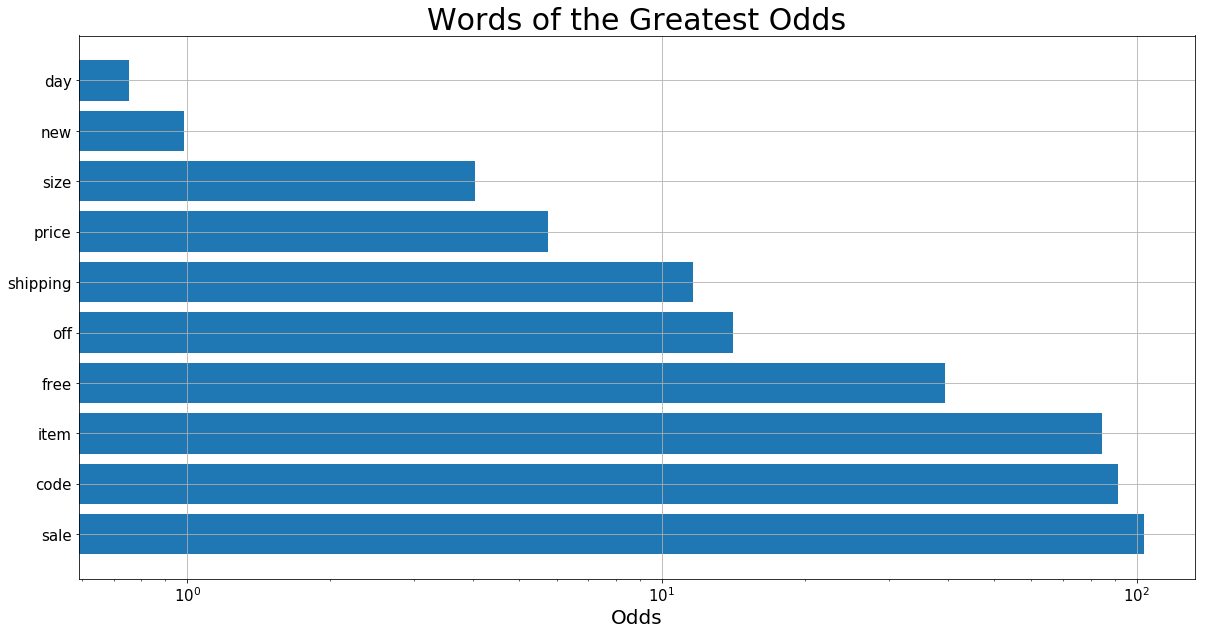

In [18]:
plt.figure(figsize=(20, 10))
plt.barh(y = features.sort_values(by='odds', ascending=False)['odds'].head(10).index,
         width= features.sort_values(by='odds', ascending=False)['odds'].head(10).values,
         log=True)
plt.title(f'Words of the Greatest Odds', fontsize=30)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('Odds', fontsize=20)
plt.grid()

Above are the words with the greatest odds from our model, meaning if a post contains any of these words, it will be more likely to be classified in `r/frugalmalefashion`.

`sale`, `code`, `item`, `free`, `off`, `shipping` have the greatest odds as those words occur the most frequently in `r/frugalmalefashion` because they represent the content of the community which is sharing deals, sales, discounts, coupons for items at stores or brands.

We will visualize the least important words from our model.

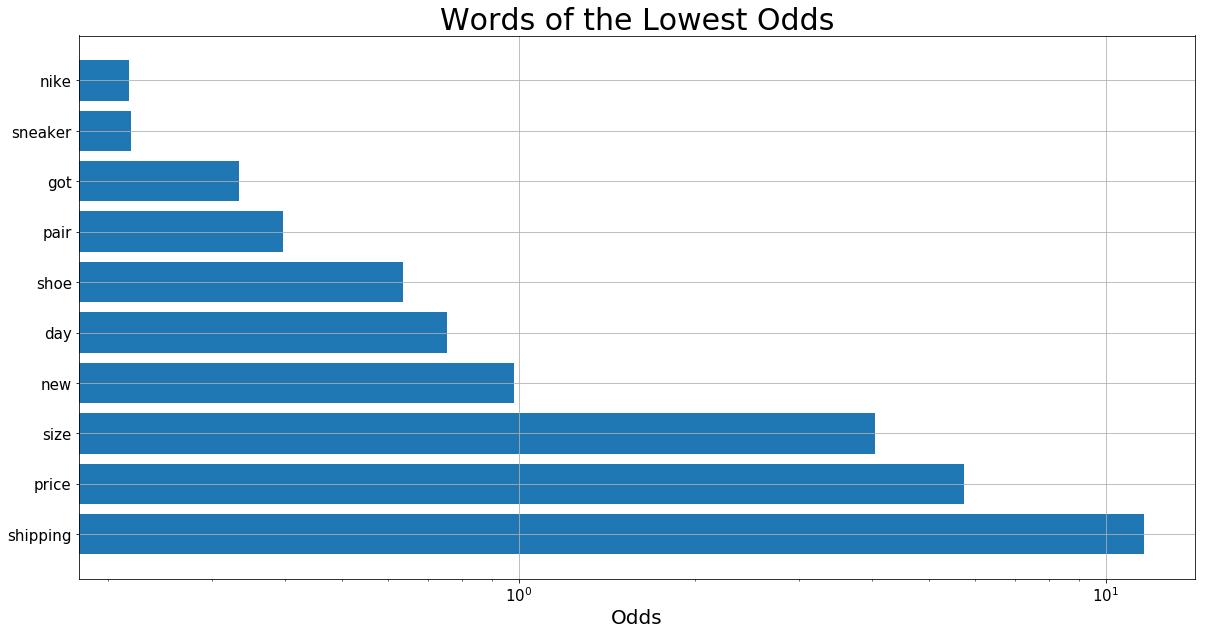

In [19]:
plt.figure(figsize=(20, 10))
plt.barh(y = features.sort_values(by='odds', ascending=False)['odds'].tail(10).index,
         width= features.sort_values(by='odds', ascending=False)['odds'].tail(10).values,
         log=True)
plt.title(f'Words of the Lowest Odds', fontsize=30)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('Odds', fontsize=20)
plt.grid()

Above are the words with the lowest odds from our model, meaning if a post contains any of these words, it will be less likely to be classified in `r/frugalmalefashion`.

`nike`, `sneaker`, `pair`, `got` are words most frequently appeared in `r/sneakers` but are associated with sneaker culture, and displaying the acquisition of sneakers rather than sharing information about sales, discounts, coupons.

#### Model Evaluation

We will evaluate our Logistic Regression model by analyzing the successful and failed predictions.

In [20]:
logr_pred = gs_logr.predict(X_test_tfidf)

We will create a confusion matrix to visualize this.

In [21]:
pd.DataFrame(confusion_matrix(y_true = y_test, y_pred = logr_pred),
             index=['True Negative', 'True Positive'],
             columns=['Predicted Negative', 'Predicted Positive'])

,Predicted Negative,Predicted Positive
True Negative,10731,620
True Positive,3849,5850


- The model correctly predicted 10731 posts to be in `r/sneakers` (true negative).
- The model correctly predicted 5850 posts to be in `r/frugalmalefashion` (true positive).
- The model incorrectly predicted 630 posts to be in `r/frugalmalefashion` when they're actually found in `r/sneakers` (false positive).
- The model incorrectly predicted 3849 posts to be in `r/sneakers` when they're actually found in `r/frugalmalefashion` (false negative).

To understand why posts are correctly or incorrectly classified, we will need to view the original text of posts with high certainty as well as low certainty.

Here are the posts in which the model predicted correctly with great confidence.

In [22]:
X_test[(gs_logr.predict_proba(X_test_tfidf)[:, 1] >= .9) & (y_test == 1)].head()

,clean_text
24330,kent curwen sample sale gone came lunchtime tr...
22292,clockwork synergy lizard grain leather watch s...
13895,uniqlo free shipping oct
30700,champion s compression short amazon size color...
25519,bean onetime off code end today


In [23]:
df['text'].loc[13895]

'uniqlo free shipping oct'

This post was correctly classified with great confidence to be in `r/frugalmalefashion`. The word `free` made this post 39.51 times more likely to be classified in `r/frugalmalefashion`. The word `shipping` made this post 11.63 times more likely to be classified in `r/frugalmalefashion`.

Here are the posts in which the model predicted incorrectly with great confidence. 

In [24]:
X_test[(gs_logr.predict_proba(X_test_tfidf)[:, 1] >= .9) & (y_test != 1)].head()

,clean_text
73596,pharrell x adidas nmd hu inspiration pack plac...
56187,footlocker code going off off
47003,legit check beluga s seller offered thing off ...
39305,normal goat second sale goat sale went fine is...
56825,favorite multifaceted kick awesome gym run fly...


In [25]:
df['text'].loc[56825]

"what are your favorite multifaceted kicks ones that look awesome but you use in the gym to run etc mine are the flyknit run frees they barely get beat up at all are super light comfy and very functional i've been a run free fan since they launched"

This post was incorrectly classified with great confidence to be in `r/frugalmalefashion`. The word `free` made this post 39.51 times more likely to be classified in `r/frugalmalefashion`.

Here are the posts in which the model predicted correctly with low confidence

In [26]:
X_test[(gs_logr.predict_proba(X_test_tfidf)[:, 1] > .4) & 
       (gs_logr.predict_proba(X_test_tfidf)[:, 1] < .6) & 
       (y_test == 1)].head()

,clean_text
10311,breathable running shoe size
32766,canada sorel boot sportchekca sorel pac nylon ...
17224,adidas canada off coupon ramkzbivydgkyspdoesn ...
9444,allen edmonds normal price buy shoe tree store...
25918,rei tretorn skymra mid gtx orange sneaker line...


In [27]:
df['text'].loc[32766]

"canada if you're looking for sorel boots sportchekca has the sorel pac nylon winter boots mens for it is eligible for bogo and they are having a no tax event combine it with the coupon you get off for signing up for their email list and you can get two pairs for hopefully you have a friend that wants one too"

This post was correctly classified with low confidence to be in `r/frugalmalefashion`. The word `off` made this post 14.14 times more likely to be classified in `r/frugalmalefashion`. The word `pair` made this post .3973 times less likely to be classified in `r/frugalmalefashion`.

Here are the posts in which the model predicted incorrectly with low confidence.

In [28]:
X_test[(gs_logr.predict_proba(X_test_tfidf)[:, 1] > .4) & 
       (gs_logr.predict_proba(X_test_tfidf)[:, 1] < .6) & 
       (y_test != 1)].head()

,clean_text
78184,cheap aj colorways hi alli m currently purchas...
62744,size air max wear jordan s jordan s size air m...
78179,european alternative goat stockx m nice altern...
41214,air jordan insole replacement recently copped ...
49859,nike epic react flyknit v free rn flyknit comf...


In [29]:
df['text'].loc[78184]

"cheap aj colorways hi alli'm currently looking to purchase a pair of ajs but the colorways i'm interested in breds chicagos etc are all way out of my price range are there any good colorways that aren't that flashy that are cheap as wellthanks"

This post was incorrectly classified with low confidence to be in `r/frugalmalefashion`. The word `pair` made this post 14.14 times less likely to be classified in `r/frugalmalefashion`. The word `price` made this post 5.74 times more likely to be classified in `r/frugalmalefashion`.

### **Conclusion and Recommendations**

The model we will put into production will the Logistic Regression model with an accuracy score of 78.77% on unseen data and with human interpretable results for downstream business applications. The model is able to provide us with the terms that best classify a post as relevant in the community of `r/frugalmalefashion` and ultimate maintain the clean environment to retain users and increase advertisement revenue.

The terms used to best classify relevant posts are: `sale`, `code`, `item`, `free`, `off`, `shipping`. These terms relate to items as being on sale such as in stores or for brands.

The terms used to be classify irrelevant posts are: `nike`, `sneaker`, `pair`. These terms are related to hype sneakerwear culture and relate to users posting about present or future acquisitions of such sneakers.

The next step of this project would be to re-evaluate the cleaning and preprocessing of the data to account for word frequency overlap between the two subreddit as well as including sentiment analysis on how words are being used in conjunction with each other in the text. After that, we could continuously collect new data to search for new signal to contribute to our model.